In [ ]:
import os
import glob
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import albumentations as A
from tqdm import tqdm
from utils import seeding, create_dir
from sklearn.model_selection import train_test_split
from ablation import BuildDoubleUNet, Conv2D, SqueezeExcitationBlock, ASPP, ViTBlock, ConvBlock, Encoder1, Encoder2, Decoder1, Decoder2
from metrics import (DiceLoss, DiceBCELoss, DiceLossMultiClass, precision, recall, F2, dice_score, jac_score, precision_multiclass, recall_multiclass, F2_multiclass, dice_score_multiclass, jac_score_multiclass, hausdorff_distance, iou_score, iou_score_multiclass, hd95, normalized_surface_dice)
import pickle

# Define the MSDDataset class
class MSDDataset(Dataset):
    def __init__(self, image_paths, mask_paths, modalities=None, slice_axis=2, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.modalities = modalities  # Should be a list of integers
        self.slice_axis = slice_axis
        self.transform = transform  # Albumentations transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        img = nib.load(self.image_paths[idx]).get_fdata()
        mask = nib.load(self.mask_paths[idx]).get_fdata()

        # Handle modalities (channels)
        if img.ndim == 4:
            # Multiple modalities
            if self.modalities is not None:
                img = img[..., self.modalities]  # Select specified modalities using indices
            channels = img.shape[-1]
        else:
            # Single modality
            img = img[..., np.newaxis]
            channels = 1

        # Per-modality normalization
        for c in range(channels):
            modality = img[..., c]
            img[..., c] = (modality - modality.min()) / (modality.max() - modality.min() + 1e-8)

        # Extract a slice along the specified axis
        mid_slice = img.shape[self.slice_axis] // 2
        img = np.take(img, mid_slice, axis=self.slice_axis)
        mask = np.take(mask, mid_slice, axis=self.slice_axis)

        # Adjust mask labels (e.g., for binary segmentation)
        mask = np.where(mask > 0, 1, 0)
        mask = mask.astype(np.int64)

        # Handle dimensions after slicing
        if img.ndim == 2:
            # Shape: [H, W]
            img = img[np.newaxis, ...]  # Shape: [1, H, W]
        elif img.ndim == 3:
            if img.shape[-1] == 1:
                # Shape: [H, W, 1]
                img = img.squeeze(-1)  # Shape: [H, W]
                img = img[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                # Shape: [H, W, C]
                img = np.transpose(img, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected img.ndim after slicing: {img.ndim}")

        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
        elif mask.ndim == 3:
            if mask.shape[-1] == 1:
                mask = mask.squeeze(-1)  # Shape: [H, W]
                mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                mask = np.transpose(mask, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected mask.ndim after slicing: {mask.ndim}")

        # Convert to NumPy arrays of type float32 and int64
        img = img.astype(np.float32)
        mask = mask.astype(np.int64)

        # Apply Albumentations transforms if provided
        if self.transform:
            # Albumentations expects images in [H, W, C] and masks in [H, W]
            img_np = img.transpose(1, 2, 0)  # [H, W, C]
            mask_np = mask.squeeze(0)        # [H, W]
            augmented = self.transform(image=img_np, mask=mask_np)
            img = augmented['image']
            mask = augmented['mask']
            # Transpose image back to [C, H, W] and add channel dimension to mask
            img = img.transpose(2, 0, 1)  # [C, H, W]
            mask = mask[np.newaxis, ...]  # [1, H, W]
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()
        else:
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()

        # Resize to 256x256
        img = F.interpolate(img.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).float(), size=(256, 256), mode='nearest').squeeze(0).long()

        return img, mask

def visualize_predictions(model, dataloader, device, num_classes, save_dir, max_batches=5):
    """
    Visualizes and saves the original images, ground truth masks, and predicted masks.

    Args:
        model (torch.nn.Module): Trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to visualize.
        device (torch.device): Device to run the model on.
        num_classes (int): Number of segmentation classes.
        save_dir (str): Directory to save the visualizations.
        max_batches (int): Number of batches to visualize.
    """
    model.eval()
    create_dir(save_dir)
    batch_count = 0

    with torch.no_grad():
        for batch_idx, (inputs, masks) in enumerate(tqdm(dataloader, desc="Visualizing")):
            inputs = inputs.to(device)
            masks = masks.to(device)

            # Perform inference
            y1_pred, y2_pred = model(inputs)
            if num_classes == 1:
                y_pred = torch.sigmoid(y2_pred)
                y_pred_binary = (y_pred > 0.5).float()
            else:
                y_pred = torch.softmax(y2_pred, dim=1)
                y_pred_binary = torch.argmax(y_pred, dim=1, keepdim=True).float()

            # Move data to CPU and convert to numpy
            inputs_np = inputs.cpu().numpy()
            masks_np = masks.cpu().numpy()
            y_pred_np = y_pred_binary.cpu().numpy()

            # Loop over batch
            for i in range(inputs_np.shape[0]):
                img = inputs_np[i]
                mask = masks_np[i]
                pred = y_pred_np[i]

                # Handle multiple channels in image
                if img.shape[0] > 1:
                    # For visualization, average across channels
                    img_display = np.mean(img, axis=0)
                else:
                    img_display = img[0]

                # Squeeze mask and prediction if they have extra dimensions
                mask_display = np.squeeze(mask)
                pred_display = np.squeeze(pred)

                # Normalize image for display
                img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min() + 1e-8)

                # Create visualization
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(img_display, cmap='gray')
                axes[0].set_title('Original Image')
                axes[0].axis('off')

                axes[1].imshow(mask_display, cmap='gray')
                axes[1].set_title('Ground Truth')
                axes[1].axis('off')

                axes[2].imshow(pred_display, cmap='gray')
                axes[2].set_title('Prediction')
                axes[2].axis('off')

                plt.tight_layout()
                save_path = os.path.join(save_dir, f'visualization_batch{batch_idx}_sample{i}.png')
                plt.savefig(save_path)
                plt.close()

            batch_count += 1
            if batch_count >= max_batches:
                break

    print(f"Visualizations saved in {save_dir}")

def load_model(save_path, config, device):
    """
    Loads the trained model based on the configuration.

    Args:
        save_path (str): Directory where the model is saved.
        config (dict): Configuration dictionary containing model parameters.
        device (torch.device): Device to load the model on.

    Returns:
        torch.nn.Module: Loaded model.
    """
    model_filename = f"best_model_aspp_{config['use_aspp']}_se_{config['use_se']}_vit_{config['use_vit']}_vit1st_{config['vit_for_first']}_vit2nd_{config['vit_for_second']}_albu_{config['use_albumentations']}.pth"
    model_path = os.path.join(save_path, model_filename)

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    # Initialize the model with task-specific parameters
    model = BuildDoubleUNet(
        in_channels=config['in_channels'],
        num_classes=config['num_classes'],
        use_aspp=config['use_aspp'],
        use_se=config['use_se'],
        use_vit=config['use_vit'],
        vit_for_first=config['vit_for_first'],
        vit_for_second=config['vit_for_second']
    )

    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model

def main():
    # Seed for reproducibility
    seeding(42)

    # Load task configuration
    with open('task_config.yaml', 'r') as f:
        task_configs = yaml.safe_load(f)

    # Specify the task
    task = 'Task01_BrainTumour'  # Change as needed

    # Define paths
    save_path_train = f'./abalation_study/{task}/train'      # Path where models are saved
    save_path_test = f'./abalation_study/{task}/test'        # Path for test results
    visualization_save_path = f'./abalation_study/{task}/visualizations'  # Path to save visualizations
    create_dir(visualization_save_path)

    # Load task-specific configurations
    config_task = task_configs[task]
    modalities = config_task['modalities']
    in_channels = config_task['in_channels']
    num_classes = config_task['num_classes']
    loss_function = config_task['loss_function']
    slice_axis = config_task['slice_axis']

    # Convert modalities to indices if they are strings
    if modalities is not None and isinstance(modalities[0], str):
        modality_name_to_index = {
            'FLAIR': 0,
            'T1w': 1,
            'T1gd': 2,
            'T2w': 3,
            'MRI': 0,
            'CT': 0,
            'T2': 0,
            'ADC': 1
            # Add other modality mappings as needed
        }
        modalities = [modality_name_to_index[m] for m in modalities]

    # Dataset paths
    image_dir = os.path.join('./dataset', task, 'imagesTr')
    mask_dir = os.path.join('./dataset', task, 'labelsTr')

    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.nii.gz')))

    # Split the data (use the same split as training)
    train_val_image_paths, test_image_paths, train_val_mask_paths, test_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=0.15, random_state=42)

    # Create Test Dataset and DataLoader (no augmentation for visualization)
    test_dataset = MSDDataset(
        test_image_paths, test_mask_paths,
        modalities=modalities, slice_axis=slice_axis,
        transform=None  # No augmentation
    )
    batch_size = 4
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Define model configurations to visualize
    configurations = [
        # {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': False},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True},
    ]

    # Iterate over each configuration and visualize predictions
    for config_idx, config_varying in enumerate(configurations):
        print(f"\nVisualizing predictions for Configuration {config_idx + 1}: {config_varying}")

        # Merge task-specific config with varying config
        config = config_task.copy()  # Start with task-specific configurations
        config.update(config_varying)  # Update with model-specific configurations

        try:
            # Load the model with the specified configuration
            model = load_model(
                save_path=save_path_train,
                config=config,
                device=device
            )
        except FileNotFoundError as e:
            print(e)
            print("Skipping this configuration.")
            continue
        except KeyError as e:
            print(f"Configuration missing key: {e}")
            print("Skipping this configuration.")
            continue

        # Define a subdirectory for this configuration's visualizations
        config_visualization_dir = os.path.join(visualization_save_path, f"final_config_{config_idx + 1}")
        create_dir(config_visualization_dir)

        # Visualize predictions
        visualize_predictions(
            model=model,
            dataloader=test_loader,
            device=device,
            num_classes=num_classes,
            save_dir=config_visualization_dir,
            max_batches=5  # Adjust as needed
        )

    print(f"\nAll visualizations are saved in {visualization_save_path}")

if __name__ == "__main__":
    main()



In [25]:
import os
import glob
import yaml
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import albumentations as A
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle

# Import your custom modules
from utils import seeding, create_dir
from metrics import dice_score, hausdorff_distance
from ablation import BuildDoubleUNet  # Ensure this is correctly imported

# Define the MSDDataset class
class MSDDataset(Dataset):
    def __init__(self, image_paths, mask_paths, modalities=None, slice_axis=2, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.modalities = modalities  # Should be a list of integers
        self.slice_axis = slice_axis
        self.transform = transform  # Albumentations transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        img = nib.load(self.image_paths[idx]).get_fdata()
        mask = nib.load(self.mask_paths[idx]).get_fdata()

        # Handle modalities (channels)
        if img.ndim == 4:
            # Multiple modalities
            if self.modalities is not None:
                img = img[..., self.modalities]  # Select specified modalities using indices
            channels = img.shape[-1]
        else:
            # Single modality
            img = img[..., np.newaxis]
            channels = 1

        # Per-modality normalization
        for c in range(channels):
            modality = img[..., c]
            img[..., c] = (modality - modality.min()) / (modality.max() - modality.min() + 1e-8)

        # Extract a slice along the specified axis
        mid_slice = img.shape[self.slice_axis] // 2
        img = np.take(img, mid_slice, axis=self.slice_axis)
        mask = np.take(mask, mid_slice, axis=self.slice_axis)

        # Adjust mask labels (e.g., for binary segmentation)
        mask = np.where(mask > 0, 1, 0)
        mask = mask.astype(np.int64)

        # Handle dimensions after slicing
        if img.ndim == 2:
            # Shape: [H, W]
            img = img[np.newaxis, ...]  # Shape: [1, H, W]
        elif img.ndim == 3:
            if img.shape[-1] == 1:
                # Shape: [H, W, 1]
                img = img.squeeze(-1)  # Shape: [H, W]
                img = img[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                # Shape: [H, W, C]
                img = np.transpose(img, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected img.ndim after slicing: {img.ndim}")

        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
        elif mask.ndim == 3:
            if mask.shape[-1] == 1:
                mask = mask.squeeze(-1)  # Shape: [H, W]
                mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                mask = np.transpose(mask, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected mask.ndim after slicing: {mask.ndim}")

        # Convert to NumPy arrays of type float32 and int64
        img = img.astype(np.float32)
        mask = mask.astype(np.int64)

        # Apply Albumentations transforms if provided
        if self.transform:
            # Albumentations expects images in [H, W, C] and masks in [H, W]
            img_np = img.transpose(1, 2, 0)  # [H, W, C]
            mask_np = mask.squeeze(0)        # [H, W]
            augmented = self.transform(image=img_np, mask=mask_np)
            img = augmented['image']
            mask = augmented['mask']
            # Transpose image back to [C, H, W] and add channel dimension to mask
            img = img.transpose(2, 0, 1)  # [C, H, W]
            mask = mask[np.newaxis, ...]  # [1, H, W]
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()
        else:
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()

        # Resize to 256x256
        img = F.interpolate(img.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).float(), size=(256, 256), mode='nearest').squeeze(0).long()

        return img, mask

def visualize_predictions(model, dataloader, device, num_classes, save_dir, max_batches=5):
    """
    Visualizes and saves the original images, ground truth masks, and predicted masks.

    Args:
        model (torch.nn.Module): Trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to visualize.
        device (torch.device): Device to run the model on.
        num_classes (int): Number of segmentation classes.
        save_dir (str): Directory to save the visualizations.
        max_batches (int): Number of batches to visualize.
    """
    model.eval()
    create_dir(save_dir)
    batch_count = 0

    with torch.no_grad():
        for batch_idx, (inputs, masks) in enumerate(tqdm(dataloader, desc="Visualizing")):
            inputs = inputs.to(device)
            masks = masks.to(device)

            # Perform inference
            y1_pred, y2_pred = model(inputs)
            if num_classes == 1:
                y_pred = torch.sigmoid(y2_pred)
                y_pred_binary = (y_pred > 0.5).float()
            else:
                y_pred = torch.softmax(y2_pred, dim=1)
                y_pred_binary = torch.argmax(y_pred, dim=1, keepdim=True).float()

            # Move data to CPU and convert to numpy
            inputs_np = inputs.cpu().numpy()
            masks_np = masks.cpu().numpy()
            y_pred_np = y_pred_binary.cpu().numpy()

            # Loop over batch
            for i in range(inputs_np.shape[0]):
                img = inputs_np[i]
                mask = masks_np[i]
                pred = y_pred_np[i]

                # Handle multiple channels in image
                if img.shape[0] > 1:
                    # For visualization, average across channels
                    img_display = np.mean(img, axis=0)
                else:
                    img_display = img[0]

                # Squeeze mask and prediction if they have extra dimensions
                mask_display = np.squeeze(mask)
                pred_display = np.squeeze(pred)

                # Normalize image for display
                img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min() + 1e-8)

                # Create visualization
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(img_display, cmap='gray')
                axes[0].set_title('Original Image')
                axes[0].axis('off')

                axes[1].imshow(mask_display, cmap='gray')
                axes[1].set_title('Ground Truth')
                axes[1].axis('off')

                axes[2].imshow(pred_display, cmap='gray')
                axes[2].set_title('Prediction')
                axes[2].axis('off')

                plt.tight_layout()
                save_path = os.path.join(save_dir, f'visualization_batch{batch_idx}_sample{i}.png')
                plt.savefig(save_path)
                plt.close()

            batch_count += 1
            if batch_count >= max_batches:
                break

    print(f"Visualizations saved in {save_dir}")

def load_model(save_path, config, device):
    """
    Loads the trained model based on the configuration.

    Args:
        save_path (str): Directory where the model is saved.
        config (dict): Configuration dictionary containing model parameters.
        device (torch.device): Device to load the model on.

    Returns:
        torch.nn.Module: Loaded model.
    """
    model_filename = f"best_model_aspp_{config['use_aspp']}_se_{config['use_se']}_vit_{config['use_vit']}_vit1st_{config['vit_for_first']}_vit2nd_{config['vit_for_second']}_albu_{config['use_albumentations']}.pth"
    model_path = os.path.join(save_path, model_filename)

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    # Load the entire model object
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model

def main():
    # Seed for reproducibility
    seeding(42)

    # Load task configuration
    with open('task_config.yaml', 'r') as f:
        task_configs = yaml.safe_load(f)

    # Specify the task
    task = 'Task01_BrainTumour'  

    # Define paths
    save_path_train = f'./abalation_study/{task}/train'          # Path where models are saved
    visualization_save_path = f'./abalation_study/{task}/visualizations'  # Path to save visualizations
    create_dir(visualization_save_path)

    # Load task-specific configurations
    config_task = task_configs[task]
    modalities = config_task['modalities']
    in_channels = config_task['in_channels']
    num_classes = config_task['num_classes']
    loss_function = config_task['loss_function']
    slice_axis = config_task['slice_axis']

    # Convert modalities to indices if they are strings
    if modalities is not None and isinstance(modalities[0], str):
        modality_name_to_index = {
            'FLAIR': 0,
            'T1w': 1,
            'T1gd': 2,
            'T2w': 3,
            'MRI': 0,
            'CT': 0,
            'T2': 0,
            'ADC': 1
            # Add other modality mappings as needed
        }
        modalities = [modality_name_to_index[m] for m in modalities]

    # Dataset paths
    image_dir = os.path.join('./dataset', task, 'imagesTr')
    mask_dir = os.path.join('./dataset', task, 'labelsTr')

    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.nii.gz')))

    # Split the data (use the same split as training)
    train_val_image_paths, test_image_paths, train_val_mask_paths, test_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=0.15, random_state=42)

    # Create Test Dataset and DataLoader (no augmentation for visualization)
    test_dataset = MSDDataset(
        test_image_paths, test_mask_paths,
        modalities=modalities, slice_axis=slice_axis,
        transform=None  # No augmentation
    )
    batch_size = 4
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Define model configurations to visualize
    configurations = [
        # Uncomment and add more configurations as needed
        # {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': False},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True},
    ]

    # Iterate over each configuration and visualize predictions
    for config_idx, config_varying in enumerate(configurations):
        print(f"\nVisualizing predictions for Configuration {config_idx + 1}: {config_varying}")

        # Merge task-specific config with varying config
        config = config_task.copy()  # Start with task-specific configurations
        config.update(config_varying)  # Update with model-specific configurations

        try:
            # Load the model with the specified configuration
            model = load_model(
                save_path=save_path_train,
                config=config,
                device=device
            )
        except FileNotFoundError as e:
            print(e)
            print("Skipping this configuration.")
            continue
        except KeyError as e:
            print(f"Configuration missing key: {e}")
            print("Skipping this configuration.")
            continue

        # Define a subdirectory for this configuration's visualizations
        config_visualization_dir = os.path.join(visualization_save_path, f"final_config_{config_idx + 1}")
        create_dir(config_visualization_dir)

        # Visualize predictions
        visualize_predictions(
            model=model,
            dataloader=test_loader,
            device=device,
            num_classes=num_classes,
            save_dir=config_visualization_dir,
            max_batches=5  # Adjust as needed
        )

    print(f"\nAll visualizations are saved in {visualization_save_path}")

if __name__ == "__main__":
    main()


Using device: cuda

Visualizing predictions for Configuration 1: {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True}


Visualizing:  21%|██        | 4/19 [00:18<00:48,  3.22s/it]


In [2]:
import os
import glob
import yaml
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import albumentations as A
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Import your custom modules
from utils import seeding, create_dir
from ablation import BuildDoubleUNet, Conv2D, SqueezeExcitationBlock, ASPP, ViTBlock, ConvBlock, Encoder1, Encoder2, Decoder1, Decoder2
from metrics import (DiceLoss, DiceBCELoss, DiceLossMultiClass, precision, recall, F2, dice_score, jac_score, precision_multiclass, recall_multiclass, F2_multiclass, dice_score_multiclass, jac_score_multiclass, hausdorff_distance, iou_score, iou_score_multiclass, hd95, normalized_surface_dice)
import pickle

# Define the MSDDataset class
class MSDDataset(Dataset):
    def __init__(self, image_paths, mask_paths, modalities=None, slice_axis=2, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.modalities = modalities  # Should be a list of integers
        self.slice_axis = slice_axis
        self.transform = transform  # Albumentations transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        img = nib.load(self.image_paths[idx]).get_fdata()
        mask = nib.load(self.mask_paths[idx]).get_fdata()

        # Handle modalities (channels)
        if img.ndim == 4:
            # Multiple modalities
            if self.modalities is not None:
                img = img[..., self.modalities]  # Select specified modalities using indices
            channels = img.shape[-1]
        else:
            # Single modality
            img = img[..., np.newaxis]
            channels = 1

        # Per-modality normalization
        for c in range(channels):
            modality = img[..., c]
            img[..., c] = (modality - modality.min()) / (modality.max() - modality.min() + 1e-8)

        # Extract a slice along the specified axis
        mid_slice = img.shape[self.slice_axis] // 2
        img = np.take(img, mid_slice, axis=self.slice_axis)
        mask = np.take(mask, mid_slice, axis=self.slice_axis)

        # Adjust mask labels (e.g., for binary segmentation)
        mask = np.where(mask > 0, 1, 0)
        mask = mask.astype(np.int64)

        # Handle dimensions after slicing
        if img.ndim == 2:
            # Shape: [H, W]
            img = img[np.newaxis, ...]  # Shape: [1, H, W]
        elif img.ndim == 3:
            if img.shape[-1] == 1:
                # Shape: [H, W, 1]
                img = img.squeeze(-1)  # Shape: [H, W]
                img = img[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                # Shape: [H, W, C]
                img = np.transpose(img, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected img.ndim after slicing: {img.ndim}")

        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
        elif mask.ndim == 3:
            if mask.shape[-1] == 1:
                mask = mask.squeeze(-1)  # Shape: [H, W]
                mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                mask = np.transpose(mask, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected mask.ndim after slicing: {mask.ndim}")

        # Convert to NumPy arrays of type float32 and int64
        img = img.astype(np.float32)
        mask = mask.astype(np.int64)

        # Apply Albumentations transforms if provided
        if self.transform:
            # Albumentations expects images in [H, W, C] and masks in [H, W]
            img_np = img.transpose(1, 2, 0)  # [H, W, C]
            mask_np = mask.squeeze(0)        # [H, W]
            augmented = self.transform(image=img_np, mask=mask_np)
            img = augmented['image']
            mask = augmented['mask']
            # Transpose image back to [C, H, W] and add channel dimension to mask
            img = img.transpose(2, 0, 1)  # [C, H, W]
            mask = mask[np.newaxis, ...]  # [1, H, W]
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()
        else:
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()

        # Resize to 256x256
        img = F.interpolate(img.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).float(), size=(256, 256), mode='nearest').squeeze(0).long()

        return img, mask

# Define the overlay function
def overlay_mask(image, mask, alpha=0.5, cmap='jet'):
    """
    Overlays a binary mask on an image.

    Args:
        image (np.ndarray): Grayscale image, shape (H, W).
        mask (np.ndarray): Binary mask, shape (H, W).
        alpha (float): Transparency factor for the mask overlay.
        cmap (str): Colormap for the mask.

    Returns:
        np.ndarray: Image with mask overlay.
    """
    colored_mask = plt.get_cmap(cmap)(mask)[:, :, :3]  # RGBA to RGB
    overlay = image[..., np.newaxis] * 0.5 + colored_mask * alpha
    overlay = np.clip(overlay, 0, 1)
    return overlay

# Define the visualization function with overlays
def visualize_predictions(model, dataloader, device, num_classes, save_dir, max_batches=5):
    """
    Visualizes and saves the original images with ground truth and predicted masks overlaid.

    Args:
        model (torch.nn.Module): Trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to visualize.
        device (torch.device): Device to run the model on.
        num_classes (int): Number of segmentation classes.
        save_dir (str): Directory to save the visualizations.
        max_batches (int): Number of batches to visualize.
    """
    model.eval()
    create_dir(save_dir)
    batch_count = 0

    with torch.no_grad():
        for batch_idx, (inputs, masks) in enumerate(tqdm(dataloader, desc="Visualizing")):
            inputs = inputs.to(device)
            masks = masks.to(device)

            # Perform inference
            y1_pred, y2_pred = model(inputs)
            if num_classes == 1:
                y_pred = torch.sigmoid(y2_pred)
                y_pred_binary = (y_pred > 0.5).float()
            else:
                y_pred = torch.softmax(y2_pred, dim=1)
                y_pred_binary = torch.argmax(y_pred, dim=1, keepdim=True).float()

            # Move data to CPU and convert to numpy
            inputs_np = inputs.cpu().numpy()
            masks_np = masks.cpu().numpy()
            y_pred_np = y_pred_binary.cpu().numpy()

            # Loop over batch
            for i in range(inputs_np.shape[0]):
                img = inputs_np[i]
                mask = masks_np[i]
                pred = y_pred_np[i]

                # Handle multiple channels in image
                if img.shape[0] > 1:
                    # For visualization, average across channels
                    img_display = np.mean(img, axis=0)
                else:
                    img_display = img[0]

                # Squeeze mask and prediction if they have extra dimensions
                mask_display = np.squeeze(mask)
                pred_display = np.squeeze(pred)

                # Normalize image for display
                img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min() + 1e-8)

                # Create overlays
                gt_overlay = overlay_mask(img_display, mask_display, alpha=0.5, cmap='jet')
                pred_overlay = overlay_mask(img_display, pred_display, alpha=0.5, cmap='jet')
                mask_display = (mask_display - mask_display.min()) / (mask_display.max() - mask_display.min() + 1e-8)
                pred_display = (pred_display - pred_display.min()) / (pred_display.max() - pred_display.min() + 1e-8)

                # Plot and save
                fig, axes = plt.subplots(1, 3, figsize=(25,10))

                axes[0].imshow(img_display, cmap='grey')
                axes[0].set_title('Original Image', fontsize=25)
                axes[0].axis('off')

                axes[1].imshow(mask_display, cmap='grey')
                axes[1].set_title('Ground Truth', fontsize=25)
                axes[1].axis('off')
                
                # axes[2].imshow(pred_display, cmap='grey')
                # axes[2].set_title('Prediction', fontsize=25)
                # axes[2].axis('off')

                axes[2].imshow(pred_overlay, cmap='jet')
                axes[2].set_title('Prediction Overlay', fontsize=25)
                axes[2].axis('off')

                # # Plot and save
                # fig, axes = plt.subplots(2, 2, figsize=(12, 6))

                # axes[0, 0].imshow(img_display, cmap='grey')
                # axes[0, 0].set_title('Original Image')
                # axes[0, 0].axis('off')

                # axes[0, 1].imshow(mask_display, cmap='grey')
                # axes[0, 1].set_title('Ground Truth')
                # axes[0, 1].axis('off')
                
                # axes[1, 0].imshow(pred_display, cmap='grey')
                # axes[1, 0].set_title('Prediction')
                # axes[1, 0].axis('off')

                # axes[1, 1].imshow(pred_overlay, cmap='jet')
                # axes[1, 1].set_title('Prediction Overlay')
                # axes[1, 1].axis('off')

                plt.tight_layout()
                save_path = os.path.join(save_dir, f'visualization_batch{batch_idx}_sample{i}.png')
                plt.savefig(save_path)
                plt.close()

            batch_count += 1
            if batch_count >= max_batches:
                break

    print(f"Visualizations saved in {save_dir}")

# Define the model loading function
def load_model(save_path, config, device):
    """
    Loads the trained model based on the configuration.

    Args:
        save_path (str): Directory where the model is saved.
        config (dict): Configuration dictionary containing model parameters.
        device (torch.device): Device to load the model on.

    Returns:
        torch.nn.Module: Loaded model.
    """
    model_filename = f"best_model_aspp_{config['use_aspp']}_se_{config['use_se']}_vit_{config['use_vit']}_vit1st_{config['vit_for_first']}_vit2nd_{config['vit_for_second']}_albu_{config['use_albumentations']}.pth"
    model_path = os.path.join(save_path, model_filename)

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    # Load the entire model object directly
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model

# Define the main function
def main(task='Task01_BrainTumour'):
    # Seed for reproducibility
    seeding(42)

    # Load task configuration
    with open('task_config.yaml', 'r') as f:
        task_configs = yaml.safe_load(f)

    # Specify the task
    # task = 'Task01_BrainTumour' 
    # task = 'Task02_Heart'
    # task = 'Task04_Hippocampus'
    # task = 'Task05_Prostate'
    # task = 'Task09_Spleen'

    # Define paths
    save_path_train = f'./abalation_study/{task}/train'          # Path where models are saved
    visualization_save_path = f'./report/{task}/'  # Path to save visualizations
    create_dir(visualization_save_path)

    # Load task-specific configurations
    config_task = task_configs[task]
    modalities = config_task['modalities']
    in_channels = config_task['in_channels']
    num_classes = config_task['num_classes']
    loss_function = config_task['loss_function']
    slice_axis = config_task['slice_axis']

    # Convert modalities to indices if they are strings
    if modalities is not None and isinstance(modalities[0], str):
        modality_name_to_index = {
            'FLAIR': 0,
            'T1w': 1,
            'T1gd': 2,
            'T2w': 3,
            'MRI': 0,
            'CT': 0,
            'T2': 0,
            'ADC': 1
        }
        modalities = [modality_name_to_index[m] for m in modalities]

    # Dataset paths
    image_dir = os.path.join('./dataset', task, 'imagesTr')
    mask_dir = os.path.join('./dataset', task, 'labelsTr')

    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.nii.gz')))

    # Split the data (use the same split as training)
    train_val_image_paths, test_image_paths, train_val_mask_paths, test_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=0.20, random_state=42)

    # Create Test Dataset and DataLoader (no augmentation for visualization)
    test_dataset = MSDDataset(
        test_image_paths, test_mask_paths,
        modalities=modalities, slice_axis=slice_axis,
        transform=None  # No augmentation
    )
    batch_size = 4
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Define model configurations to visualize
    configurations = [
        # Uncomment and add more configurations as needed
        {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': False},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': True},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': False},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True},
    ]

    # Iterate over each configuration and visualize predictions
    for config_idx, config_varying in enumerate(configurations):
        print(f"\nVisualizing predictions for Configuration {config_idx + 1}: {config_varying}")

        # Merge task-specific config with varying config
        config = config_task.copy()  # Start with task-specific configurations
        config.update(config_varying)  # Update with model-specific configurations

        try:
            # Load the model with the specified configuration
            model = load_model(
                save_path=save_path_train,
                config=config,
                device=device
            )
        except FileNotFoundError as e:
            print(e)
            print("Skipping this configuration.")
            continue
        except KeyError as e:
            print(f"Configuration missing key: {e}")
            print("Skipping this configuration.")
            continue

        # Define a subdirectory for this configuration's visualizations
        config_visualization_dir = os.path.join(visualization_save_path, f"config{config_idx + 1}")
        create_dir(config_visualization_dir)

        # Visualize predictions
        visualize_predictions(
            model=model,
            dataloader=test_loader,
            device=device,
            num_classes=num_classes,
            save_dir=config_visualization_dir,
            max_batches=5
        )

    print(f"\nAll visualizations are saved in {visualization_save_path}")

if __name__ == "__main__":
    for task in ['Task01_BrainTumour', 'Task02_Heart', 'Task04_Hippocampus']:
    # for task in ['Task01_BrainTumour']:
    # , 'Task05_Prostate', 'Task09_Spleen']:
        main(task=task)

Using device: cuda

Visualizing predictions for Configuration 1: {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False}
Visualizations saved in ./report/Task01_BrainTumour/config1

Visualizing predictions for Configuration 2: {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True}
Visualizations saved in ./report/Task01_BrainTumour/config2

Visualizing predictions for Configuration 3: {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False}
Visualizations saved in ./report/Task01_BrainTumour/config3

Visualizing predictions for Configuration 4: {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True}
Visualizations saved in ./report/Task01_BrainTumour/config4

Visualizing predictions for 

Visualizing:  31%|███       | 4/13 [00:09<00:21,  2.37s/it]


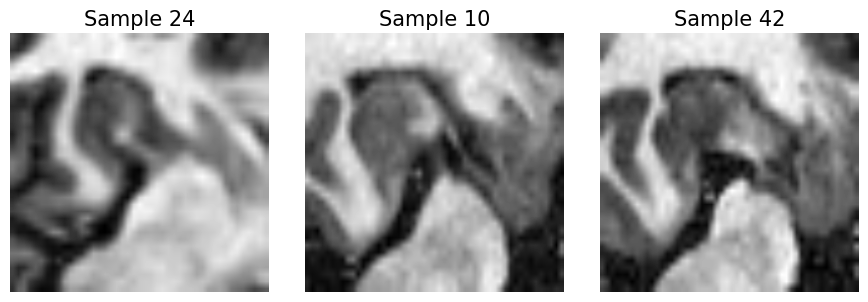

In [28]:
def visualize_random_samples(dataloader, num_samples, save_dir):
    """
    Visualizes and saves a set of random original images from the dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        num_samples (int): Number of random samples to display.
        save_dir (str): Directory to save the visualization.
    """
    create_dir(save_dir)
    total_samples = len(dataloader.dataset)
    random_indices = random.sample(range(total_samples), num_samples)
    selected_imgs = []
    # print(random_indices)
    random_indices = [24, 10, 42]
    dataset = dataloader.dataset
    for idx in random_indices:
        [54, 19, 11]
        img, _ = dataset[idx]
        img_np = img.numpy()
        selected_imgs.append(img_np)

    # Create a figure to display images side by side
    fig, axes = plt.subplots(1, num_samples, figsize=(3 * num_samples, 3))
    for idx, img in enumerate(selected_imgs):
        # Handle multiple channels in image
        if img.shape[0] > 1:
            img_display = np.mean(img, axis=0)
        else:
            img_display = img[0]

        # Normalize image for display
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min() + 1e-8)

        axes[idx].imshow(img_display, cmap='gray')
        axes[idx].set_title(f'Sample {random_indices[idx]}', fontsize=15)
        axes[idx].axis('off')

    plt.tight_layout()
    # save_path = os.path.join(save_dir, 'random_original_images.png')
    # plt.savefig(save_path)
    plt.show()
    plt.close()

    # print(f"Random samples of original images saved in {save_path}")


# Load task configuration
with open('task_config.yaml', 'r') as f:
    task_configs = yaml.safe_load(f)    

task = 'Task04_Hippocampus'

# Define paths
save_path_train = f'./abalation_study/{task}/train'          # Path where models are saved
visualization_save_path = f'./report/'  # Path to save visualizations
create_dir(visualization_save_path)

# Load task-specific configurations
config_task = task_configs[task]
modalities = config_task['modalities']
in_channels = config_task['in_channels']
num_classes = config_task['num_classes']
loss_function = config_task['loss_function']
slice_axis = config_task['slice_axis']

# Convert modalities to indices if they are strings
if modalities is not None and isinstance(modalities[0], str):
    modality_name_to_index = {
        'FLAIR': 0,
        'T1w': 1,
        'T1gd': 2,
        'T2w': 3,
        'MRI': 0,
        'CT': 0,
        'T2': 0,
        'ADC': 1
    }
    modalities = [modality_name_to_index[m] for m in modalities]

# Dataset paths
image_dir = os.path.join('./dataset', task, 'imagesTr')
mask_dir = os.path.join('./dataset', task, 'labelsTr')

image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.nii.gz')))

# Split the data (use the same split as training)
train_val_image_paths, test_image_paths, train_val_mask_paths, test_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.20, random_state=42)

# Create Test Dataset and DataLoader (no augmentation for visualization)
test_dataset = MSDDataset(
    test_image_paths, test_mask_paths,
    modalities=modalities, slice_axis=slice_axis,
    transform=None  # No augmentation
)
batch_size = 4 #[54, 19, 11] [24, 10, 42]
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

visualize_random_samples(dataloader=test_loader, num_samples=3, save_dir=visualization_save_path)

In [4]:
import random
from torch.utils.data import DataLoader, Dataset


In [15]:
import os
import glob
import yaml
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import albumentations as A
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Import your custom modules
from utils import seeding, create_dir
from ablation import BuildDoubleUNet
from metrics import dice_score, hausdorff_distance

# Define the MSDDataset class
class MSDDataset(Dataset):
    def __init__(self, image_paths, mask_paths, modalities=None, slice_axis=2, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.modalities = modalities  # Should be a list of integers
        self.slice_axis = slice_axis
        self.transform = transform  # Albumentations transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        img = nib.load(self.image_paths[idx]).get_fdata()
        mask = nib.load(self.mask_paths[idx]).get_fdata()

        # Handle modalities (channels)
        if img.ndim == 4:
            # Multiple modalities
            if self.modalities is not None:
                img = img[..., self.modalities]  # Select specified modalities using indices
            channels = img.shape[-1]
        else:
            # Single modality
            img = img[..., np.newaxis]
            channels = 1

        # Per-modality normalization
        for c in range(channels):
            modality = img[..., c]
            img[..., c] = (modality - modality.min()) / (modality.max() - modality.min() + 1e-8)

        # Extract a slice along the specified axis
        mid_slice = img.shape[self.slice_axis] // 2
        img = np.take(img, mid_slice, axis=self.slice_axis)
        mask = np.take(mask, mid_slice, axis=self.slice_axis)

        # Adjust mask labels (e.g., for binary segmentation)
        mask = np.where(mask > 0, 1, 0)
        mask = mask.astype(np.int64)

        # Handle dimensions after slicing
        if img.ndim == 2:
            # Shape: [H, W]
            img = img[np.newaxis, ...]  # Shape: [1, H, W]
        elif img.ndim == 3:
            if img.shape[-1] == 1:
                # Shape: [H, W, 1]
                img = img.squeeze(-1)  # Shape: [H, W]
                img = img[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                # Shape: [H, W, C]
                img = np.transpose(img, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected img.ndim after slicing: {img.ndim}")

        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
        elif mask.ndim == 3:
            if mask.shape[-1] == 1:
                mask = mask.squeeze(-1)  # Shape: [H, W]
                mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                mask = np.transpose(mask, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected mask.ndim after slicing: {mask.ndim}")

        # Convert to NumPy arrays of type float32 and int64
        img = img.astype(np.float32)
        mask = mask.astype(np.int64)

        # Apply Albumentations transforms if provided
        if self.transform:
            # Albumentations expects images in [H, W, C] and masks in [H, W]
            img_np = img.transpose(1, 2, 0)  # [H, W, C]
            mask_np = mask.squeeze(0)        # [H, W]
            augmented = self.transform(image=img_np, mask=mask_np)
            img = augmented['image']
            mask = augmented['mask']
            # Transpose image back to [C, H, W] and add channel dimension to mask
            img = img.transpose(2, 0, 1)  # [C, H, W]
            mask = mask[np.newaxis, ...]  # [1, H, W]
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()
        else:
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()

        # Resize to 256x256
        img = F.interpolate(img.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).float(), size=(256, 256), mode='nearest').squeeze(0).long()

        return img, mask

# Define the overlay function
def overlay_mask(image, mask, alpha=0.5, cmap='jet'):
    """
    Overlays a binary mask on an image.

    Args:
        image (np.ndarray): Grayscale image, shape (H, W).
        mask (np.ndarray): Binary mask, shape (H, W).
        alpha (float): Transparency factor for the mask overlay.
        cmap (str): Colormap for the mask.

    Returns:
        np.ndarray: Image with mask overlay.
    """
    colored_mask = plt.get_cmap(cmap)(mask)[:, :, :3]  # RGBA to RGB
    overlay = image[..., np.newaxis] * 0.5 + colored_mask * alpha
    overlay = np.clip(overlay, 0, 1)
    return overlay

# Define the visualization function with overlays
def visualize_predictions(model, dataloader, device, num_classes, save_dir, max_batches=5):
    """
    Visualizes and saves the original images with ground truth and predicted masks overlaid.

    Args:
        model (torch.nn.Module): Trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to visualize.
        device (torch.device): Device to run the model on.
        num_classes (int): Number of segmentation classes.
        save_dir (str): Directory to save the visualizations.
        max_batches (int): Number of batches to visualize.
    """
    model.eval()
    create_dir(save_dir)
    batch_count = 0

    with torch.no_grad():
        for batch_idx, (inputs, masks) in enumerate(tqdm(dataloader, desc="Visualizing")):
            inputs = inputs.to(device)
            masks = masks.to(device)

            # Perform inference
            y1_pred, y2_pred = model(inputs)
            if num_classes == 1:
                y_pred = torch.sigmoid(y2_pred)
                y_pred_binary = (y_pred > 0.5).float()
            else:
                y_pred = torch.softmax(y2_pred, dim=1)
                y_pred_binary = torch.argmax(y_pred, dim=1, keepdim=True).float()

            # Move data to CPU and convert to numpy
            inputs_np = inputs.cpu().numpy()
            masks_np = masks.cpu().numpy()
            y_pred_np = y_pred_binary.cpu().numpy()

            # Loop over batch
            for i in range(inputs_np.shape[0]):
                img = inputs_np[i]
                mask = masks_np[i]
                pred = y_pred_np[i]

                # Handle multiple channels in image
                if img.shape[0] > 1:
                    # For visualization, average across channels
                    img_display = np.mean(img, axis=0)
                else:
                    img_display = img[0]

                # Squeeze mask and prediction if they have extra dimensions
                mask_display = np.squeeze(mask)
                pred_display = np.squeeze(pred)

                # Normalize image for display
                img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min() + 1e-8)

                # Create overlays
                gt_overlay = overlay_mask(img_display, mask_display, alpha=0.5, cmap='jet')
                pred_overlay = overlay_mask(img_display, pred_display, alpha=0.5, cmap='hot')  # Different cmap for prediction

                # Plot and save
                fig, axes = plt.subplots(2, 2, figsize=(20, 12))

                # Row 1: Without overlays
                axes[0, 0].imshow(img_display, cmap='gray')
                axes[0, 0].set_title('Original Image')
                axes[0, 0].axis('off')

                axes[0, 1].imshow(mask_display, cmap='gray')
                axes[0, 1].set_title('Ground Truth Mask')
                axes[0, 1].axis('off')

                # Row 2: With overlays
                axes[1, 0].imshow(img_display, cmap='gray')
                axes[1, 0].imshow(mask_display, cmap='jet', alpha=0.5)
                axes[1, 0].set_title('Ground Truth Overlay')
                axes[1, 0].axis('off')

                axes[1, 1].imshow(img_display, cmap='gray')
                axes[1, 1].imshow(pred_display, cmap='hot', alpha=0.5)
                axes[1, 1].set_title('Prediction Overlay')
                axes[1, 1].axis('off')

                plt.tight_layout()
                save_path = os.path.join(save_dir, f'visualization_batch{batch_idx}_sample{i}.png')
                plt.savefig(save_path)
                plt.close()

            batch_count += 1
            if batch_count >= max_batches:
                break

    print(f"Visualizations saved in {save_dir}")

# Define the model loading function
def load_model(save_path, config, device):
    """
    Loads the trained model based on the configuration.

    Args:
        save_path (str): Directory where the model is saved.
        config (dict): Configuration dictionary containing model parameters.
        device (torch.device): Device to load the model on.

    Returns:
        torch.nn.Module: Loaded model.
    """
    model_filename = f"best_model_aspp_{config['use_aspp']}_se_{config['use_se']}_vit_{config['use_vit']}_vit1st_{config['vit_for_first']}_vit2nd_{config['vit_for_second']}_albu_{config['use_albumentations']}.pth"
    model_path = os.path.join(save_path, model_filename)

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    # Load the entire model object directly
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model

# Define the main function
def main():
    # Seed for reproducibility
    seeding(42)

    # Load task configuration
    with open('task_config.yaml', 'r') as f:
        task_configs = yaml.safe_load(f)

    # Specify the task
    task = 'Task01_BrainTumour'  # Change as needed

    # Define paths
    save_path_train = f'./abalation_study/{task}/train'          # Path where models are saved
    visualization_save_path = f'./abalation_study/{task}/visualizations'  # Path to save visualizations
    create_dir(visualization_save_path)

    # Load task-specific configurations
    config_task = task_configs[task]
    modalities = config_task['modalities']
    in_channels = config_task['in_channels']
    num_classes = config_task['num_classes']
    loss_function = config_task['loss_function']
    slice_axis = config_task['slice_axis']

    # Convert modalities to indices if they are strings
    if modalities is not None and isinstance(modalities[0], str):
        modality_name_to_index = {
            'FLAIR': 0,
            'T1w': 1,
            'T1gd': 2,
            'T2w': 3,
            'MRI': 0,
            'CT': 0,
            'T2': 0,
            'ADC': 1
            # Add other modality mappings as needed
        }
        modalities = [modality_name_to_index[m] for m in modalities]

    # Dataset paths
    image_dir = os.path.join('./dataset', task, 'imagesTr')
    mask_dir = os.path.join('./dataset', task, 'labelsTr')

    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.nii.gz')))

    # Split the data (use the same split as training)
    train_val_image_paths, test_image_paths, train_val_mask_paths, test_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=0.15, random_state=42)

    # Create Test Dataset and DataLoader (no augmentation for visualization)
    test_dataset = MSDDataset(
        test_image_paths, test_mask_paths,
        modalities=modalities, slice_axis=slice_axis,
        transform=None  # No augmentation
    )
    batch_size = 4
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Define model configurations to visualize
    configurations = [
        # Uncomment and add more configurations as needed
        # {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': False},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True},
    ]

    # Iterate over each configuration and visualize predictions
    for config_idx, config_varying in enumerate(configurations):
        print(f"\nVisualizing predictions for Configuration {config_idx + 1}: {config_varying}")

        # Merge task-specific config with varying config
        config = config_task.copy()  # Start with task-specific configurations
        config.update(config_varying)  # Update with model-specific configurations

        try:
            # Load the model with the specified configuration
            model = load_model(
                save_path=save_path_train,
                config=config,
                device=device
            )
        except FileNotFoundError as e:
            print(e)
            print("Skipping this configuration.")
            continue
        except KeyError as e:
            print(f"Configuration missing key: {e}")
            print("Skipping this configuration.")
            continue

        # Define a subdirectory for this configuration's visualizations
        config_visualization_dir = os.path.join(visualization_save_path, f"config_new_{config_idx + 1}")
        create_dir(config_visualization_dir)

        # Visualize predictions
        visualize_predictions(
            model=model,
            dataloader=test_loader,
            device=device,
            num_classes=num_classes,
            save_dir=config_visualization_dir,
            max_batches=5  # Adjust as needed
        )

    print(f"\nAll visualizations are saved in {visualization_save_path}")

if __name__ == "__main__":
    main()


Using device: cuda

Visualizing predictions for Configuration 1: {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True}


Visualizing:  21%|██        | 4/19 [00:20<01:03,  4.25s/it]


In [16]:
import os
import glob
import yaml
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import albumentations as A
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Import your custom modules
from utils import seeding, create_dir
from ablation import BuildDoubleUNet
from metrics import dice_score, hausdorff_distance

# Define the MSDDataset class
class MSDDataset(Dataset):
    def __init__(self, image_paths, mask_paths, modalities=None, slice_axis=2, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.modalities = modalities  # Should be a list of integers
        self.slice_axis = slice_axis
        self.transform = transform  # Albumentations transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        img = nib.load(self.image_paths[idx]).get_fdata()
        mask = nib.load(self.mask_paths[idx]).get_fdata()

        # Handle modalities (channels)
        if img.ndim == 4:
            # Multiple modalities
            if self.modalities is not None:
                img = img[..., self.modalities]  # Select specified modalities using indices
            channels = img.shape[-1]
        else:
            # Single modality
            img = img[..., np.newaxis]
            channels = 1

        # Per-modality normalization
        for c in range(channels):
            modality = img[..., c]
            img[..., c] = (modality - modality.min()) / (modality.max() - modality.min() + 1e-8)

        # Extract a slice along the specified axis
        mid_slice = img.shape[self.slice_axis] // 2
        img = np.take(img, mid_slice, axis=self.slice_axis)
        mask = np.take(mask, mid_slice, axis=self.slice_axis)

        # Adjust mask labels (e.g., for binary segmentation)
        mask = np.where(mask > 0, 1, 0)
        mask = mask.astype(np.int64)

        # Handle dimensions after slicing
        if img.ndim == 2:
            # Shape: [H, W]
            img = img[np.newaxis, ...]  # Shape: [1, H, W]
        elif img.ndim == 3:
            if img.shape[-1] == 1:
                # Shape: [H, W, 1]
                img = img.squeeze(-1)  # Shape: [H, W]
                img = img[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                # Shape: [H, W, C]
                img = np.transpose(img, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected img.ndim after slicing: {img.ndim}")

        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
        elif mask.ndim == 3:
            if mask.shape[-1] == 1:
                mask = mask.squeeze(-1)  # Shape: [H, W]
                mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                mask = np.transpose(mask, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected mask.ndim after slicing: {mask.ndim}")

        # Convert to NumPy arrays of type float32 and int64
        img = img.astype(np.float32)
        mask = mask.astype(np.int64)

        # Apply Albumentations transforms if provided
        if self.transform:
            # Albumentations expects images in [H, W, C] and masks in [H, W]
            img_np = img.transpose(1, 2, 0)  # [H, W, C]
            mask_np = mask.squeeze(0)        # [H, W]
            augmented = self.transform(image=img_np, mask=mask_np)
            img = augmented['image']
            mask = augmented['mask']
            # Transpose image back to [C, H, W] and add channel dimension to mask
            img = img.transpose(2, 0, 1)  # [C, H, W]
            mask = mask[np.newaxis, ...]  # [1, H, W]
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()
        else:
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()

        # Resize to 256x256
        img = F.interpolate(img.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).float(), size=(256, 256), mode='nearest').squeeze(0).long()

        return img, mask

# Define the overlay function
def overlay_mask(image, mask, alpha=0.5, cmap='jet'):
    """
    Overlays a binary mask on an image.

    Args:
        image (np.ndarray): Grayscale image, shape (H, W).
        mask (np.ndarray): Binary mask, shape (H, W).
        alpha (float): Transparency factor for the mask overlay.
        cmap (str): Colormap for the mask.

    Returns:
        np.ndarray: Image with mask overlay.
    """
    colored_mask = plt.get_cmap(cmap)(mask)[:, :, :3]  # RGBA to RGB
    overlay = image[..., np.newaxis] * 0.5 + colored_mask * alpha
    overlay = np.clip(overlay, 0, 1)
    return overlay

# Define the visualization function with overlays
def visualize_predictions(model, dataloader, device, num_classes, save_dir, max_batches=5):
    """
    Visualizes and saves the original images, ground truth masks, prediction masks, and their overlays.

    Args:
        model (torch.nn.Module): Trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to visualize.
        device (torch.device): Device to run the model on.
        num_classes (int): Number of segmentation classes.
        save_dir (str): Directory to save the visualizations.
        max_batches (int): Number of batches to visualize.
    """
    model.eval()
    create_dir(save_dir)
    batch_count = 0

    with torch.no_grad():
        for batch_idx, (inputs, masks) in enumerate(tqdm(dataloader, desc="Visualizing")):
            inputs = inputs.to(device)
            masks = masks.to(device)

            # Perform inference
            y1_pred, y2_pred = model(inputs)
            if num_classes == 1:
                y_pred = torch.sigmoid(y2_pred)
                y_pred_binary = (y_pred > 0.5).float()
            else:
                y_pred = torch.softmax(y2_pred, dim=1)
                y_pred_binary = torch.argmax(y_pred, dim=1, keepdim=True).float()

            # Move data to CPU and convert to numpy
            inputs_np = inputs.cpu().numpy()
            masks_np = masks.cpu().numpy()
            y_pred_np = y_pred_binary.cpu().numpy()

            # Loop over batch
            for i in range(inputs_np.shape[0]):
                img = inputs_np[i]
                mask = masks_np[i]
                pred = y_pred_np[i]

                # Handle multiple channels in image
                if img.shape[0] > 1:
                    # For visualization, average across channels
                    img_display = np.mean(img, axis=0)
                else:
                    img_display = img[0]

                # Squeeze mask and prediction if they have extra dimensions
                mask_display = np.squeeze(mask)
                pred_display = np.squeeze(pred)

                # Normalize image for display
                img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min() + 1e-8)

                # Create overlays
                gt_overlay = overlay_mask(img_display, mask_display, alpha=0.5, cmap='jet')
                pred_overlay = overlay_mask(img_display, pred_display, alpha=0.5, cmap='hot')  # Different cmap for prediction

                # Plot and save
                fig, axes = plt.subplots(2, 3, figsize=(24, 16))

                # Top Row: Without Overlays
                axes[0, 0].imshow(img_display, cmap='gray')
                axes[0, 0].set_title('Original Image')
                axes[0, 0].axis('off')

                axes[0, 1].imshow(mask_display, cmap='gray')
                axes[0, 1].set_title('Ground Truth Mask')
                axes[0, 1].axis('off')

                axes[0, 2].imshow(pred_display, cmap='gray')
                axes[0, 2].set_title('Prediction Mask')
                axes[0, 2].axis('off')

                # Bottom Row: With Overlays
                axes[1, 0].imshow(img_display, cmap='gray')
                axes[1, 0].imshow(mask_display, cmap='jet', alpha=0.5)
                axes[1, 0].set_title('Ground Truth Overlay')
                axes[1, 0].axis('off')

                axes[1, 1].imshow(img_display, cmap='gray')
                axes[1, 1].imshow(pred_display, cmap='hot', alpha=0.5)
                axes[1, 1].set_title('Prediction Overlay')
                axes[1, 1].axis('off')

                # Combined Overlay (Optional)
                combined_overlay = np.clip(gt_overlay * 0.5 + pred_overlay * 0.5, 0, 1)
                axes[1, 2].imshow(img_display, cmap='gray')
                axes[1, 2].imshow(combined_overlay)
                axes[1, 2].set_title('Combined Overlays')
                axes[1, 2].axis('off')

                plt.tight_layout()
                save_path = os.path.join(save_dir, f'visualization_batch{batch_idx}_sample{i}.png')
                plt.savefig(save_path)
                plt.close()

            batch_count += 1
            if batch_count >= max_batches:
                break

    print(f"Visualizations saved in {save_dir}")

# Define the model loading function
def load_model(save_path, config, device):
    """
    Loads the trained model based on the configuration.

    Args:
        save_path (str): Directory where the model is saved.
        config (dict): Configuration dictionary containing model parameters.
        device (torch.device): Device to load the model on.

    Returns:
        torch.nn.Module: Loaded model.
    """
    model_filename = f"best_model_aspp_{config['use_aspp']}_se_{config['use_se']}_vit_{config['use_vit']}_vit1st_{config['vit_for_first']}_vit2nd_{config['vit_for_second']}_albu_{config['use_albumentations']}.pth"
    model_path = os.path.join(save_path, model_filename)

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    # Load the entire model object directly
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model

# Define the main function
def main():
    # Seed for reproducibility
    seeding(42)

    # Load task configuration
    with open('task_config.yaml', 'r') as f:
        task_configs = yaml.safe_load(f)

    # Specify the task
    task = 'Task01_BrainTumour'  # Change as needed

    # Define paths
    save_path_train = f'./abalation_study/{task}/train'          # Path where models are saved
    visualization_save_path = f'./abalation_study/{task}/visualizations'  # Path to save visualizations
    create_dir(visualization_save_path)

    # Load task-specific configurations
    config_task = task_configs[task]
    modalities = config_task['modalities']
    in_channels = config_task['in_channels']
    num_classes = config_task['num_classes']
    loss_function = config_task['loss_function']
    slice_axis = config_task['slice_axis']

    # Convert modalities to indices if they are strings
    if modalities is not None and isinstance(modalities[0], str):
        modality_name_to_index = {
            'FLAIR': 0,
            'T1w': 1,
            'T1gd': 2,
            'T2w': 3,
            'MRI': 0,
            'CT': 0,
            'T2': 0,
            'ADC': 1
            # Add other modality mappings as needed
        }
        modalities = [modality_name_to_index[m] for m in modalities]

    # Dataset paths
    image_dir = os.path.join('./dataset', task, 'imagesTr')
    mask_dir = os.path.join('./dataset', task, 'labelsTr')

    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.nii.gz')))

    # Split the data (use the same split as training)
    train_val_image_paths, test_image_paths, train_val_mask_paths, test_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=0.15, random_state=42)

    # Create Test Dataset and DataLoader (no augmentation for visualization)
    test_dataset = MSDDataset(
        test_image_paths, test_mask_paths,
        modalities=modalities, slice_axis=slice_axis,
        transform=None  # No augmentation
    )
    batch_size = 4
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Define model configurations to visualize
    configurations = [
        # Uncomment and add more configurations as needed
        # {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': False},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True},
    ]

    # Iterate over each configuration and visualize predictions
    for config_idx, config_varying in enumerate(configurations):
        print(f"\nVisualizing predictions for Configuration {config_idx + 1}: {config_varying}")

        # Merge task-specific config with varying config
        config = config_task.copy()  # Start with task-specific configurations
        config.update(config_varying)  # Update with model-specific configurations

        try:
            # Load the model with the specified configuration
            model = load_model(
                save_path=save_path_train,
                config=config,
                device=device
            )
        except FileNotFoundError as e:
            print(e)
            print("Skipping this configuration.")
            continue
        except KeyError as e:
            print(f"Configuration missing key: {e}")
            print("Skipping this configuration.")
            continue

        # Define a subdirectory for this configuration's visualizations
        config_visualization_dir = os.path.join(visualization_save_path, f"config_test_{config_idx + 1}")
        create_dir(config_visualization_dir)

        # Visualize predictions
        visualize_predictions(
            model=model,
            dataloader=test_loader,
            device=device,
            num_classes=num_classes,
            save_dir=config_visualization_dir,
            max_batches=5  # Adjust as needed
        )

    print(f"\nAll visualizations are saved in {visualization_save_path}")

if __name__ == "__main__":
    main()


Using device: cuda

Visualizing predictions for Configuration 1: {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True}


Visualizing:  21%|██        | 4/19 [00:33<01:52,  7.49s/it]


In [23]:
import os
import glob
import yaml
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import albumentations as A
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Import your custom modules
from utils import seeding, create_dir
from ablation import BuildDoubleUNet
from metrics import dice_score, hausdorff_distance

# Define the MSDDataset class
class MSDDataset(Dataset):
    def __init__(self, image_paths, mask_paths, modalities=None, slice_axis=2, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.modalities = modalities  # Should be a list of integers
        self.slice_axis = slice_axis
        self.transform = transform  # Albumentations transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        img = nib.load(self.image_paths[idx]).get_fdata()
        mask = nib.load(self.mask_paths[idx]).get_fdata()

        # Handle modalities (channels)
        if img.ndim == 4:
            # Multiple modalities
            if self.modalities is not None:
                img = img[..., self.modalities]  # Select specified modalities using indices
            channels = img.shape[-1]
        else:
            # Single modality
            img = img[..., np.newaxis]
            channels = 1

        # Per-modality normalization
        for c in range(channels):
            modality = img[..., c]
            img[..., c] = (modality - modality.min()) / (modality.max() - modality.min() + 1e-8)

        # Extract a slice along the specified axis
        mid_slice = img.shape[self.slice_axis] // 2
        img = np.take(img, mid_slice, axis=self.slice_axis)
        mask = np.take(mask, mid_slice, axis=self.slice_axis)

        # Adjust mask labels (e.g., for binary segmentation)
        mask = np.where(mask > 0, 1, 0)
        mask = mask.astype(np.int64)

        # Handle dimensions after slicing
        if img.ndim == 2:
            # Shape: [H, W]
            img = img[np.newaxis, ...]  # Shape: [1, H, W]
        elif img.ndim == 3:
            if img.shape[-1] == 1:
                # Shape: [H, W, 1]
                img = img.squeeze(-1)  # Shape: [H, W]
                img = img[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                # Shape: [H, W, C]
                img = np.transpose(img, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected img.ndim after slicing: {img.ndim}")

        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
        elif mask.ndim == 3:
            if mask.shape[-1] == 1:
                mask = mask.squeeze(-1)  # Shape: [H, W]
                mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                mask = np.transpose(mask, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected mask.ndim after slicing: {mask.ndim}")

        # Convert to NumPy arrays of type float32 and int64
        img = img.astype(np.float32)
        mask = mask.astype(np.int64)

        # Apply Albumentations transforms if provided
        if self.transform:
            # Albumentations expects images in [H, W, C] and masks in [H, W]
            img_np = img.transpose(1, 2, 0)  # [H, W, C]
            mask_np = mask.squeeze(0)        # [H, W]
            augmented = self.transform(image=img_np, mask=mask_np)
            img = augmented['image']
            mask = augmented['mask']
            # Transpose image back to [C, H, W] and add channel dimension to mask
            img = img.transpose(2, 0, 1)  # [C, H, W]
            mask = mask[np.newaxis, ...]  # [1, H, W]
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()
        else:
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()

        # Resize to 256x256
        img = F.interpolate(img.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).float(), size=(256, 256), mode='nearest').squeeze(0).long()

        return img, mask

# Define the overlay function
def overlay_mask(image, mask, alpha=0.5, cmap='jet'):
    """
    Overlays a binary mask on an image.

    Args:
        image (np.ndarray): Grayscale image, shape (H, W).
        mask (np.ndarray): Binary mask, shape (H, W).
        alpha (float): Transparency factor for the mask overlay.
        cmap (str): Colormap for the mask.

    Returns:
        np.ndarray: Image with mask overlay.
    """
    colored_mask = plt.get_cmap(cmap)(mask)[:, :, :3]  # RGBA to RGB
    overlay = image[..., np.newaxis] * 0.5 + colored_mask * alpha
    overlay = np.clip(overlay, 0, 1)
    return overlay

# Define the visualization function with overlays
def visualize_predictions(model, dataloader, device, num_classes, save_dir, max_batches=5):
    """
    Visualizes and saves the original images, ground truth masks, prediction masks, and their overlays.

    Args:
        model (torch.nn.Module): Trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to visualize.
        device (torch.device): Device to run the model on.
        num_classes (int): Number of segmentation classes.
        save_dir (str): Directory to save the visualizations.
        max_batches (int): Number of batches to visualize.
    """
    model.eval()
    create_dir(save_dir)
    batch_count = 0

    with torch.no_grad():
        for batch_idx, (inputs, masks) in enumerate(tqdm(dataloader, desc="Visualizing")):
            inputs = inputs.to(device)
            masks = masks.to(device)

            # Perform inference
            y1_pred, y2_pred = model(inputs)
            if num_classes == 1:
                y_pred = torch.sigmoid(y2_pred)
                y_pred_binary = (y_pred > 0.5).float()
            else:
                y_pred = torch.softmax(y2_pred, dim=1)
                y_pred_binary = torch.argmax(y_pred, dim=1, keepdim=True).float()

            # Move data to CPU and convert to numpy
            inputs_np = inputs.cpu().numpy()
            masks_np = masks.cpu().numpy()
            y_pred_np = y_pred_binary.cpu().numpy()

            # Loop over batch
            for i in range(inputs_np.shape[0]):
                img = inputs_np[i]
                mask = masks_np[i]
                pred = y_pred_np[i]

                # Handle multiple channels in image
                if img.shape[0] > 1:
                    # For visualization, average across channels
                    img_display = np.mean(img, axis=0)
                else:
                    img_display = img[0]

                # Squeeze mask and prediction if they have extra dimensions
                mask_display = np.squeeze(mask)
                pred_display = np.squeeze(pred)

                # Normalize image for display
                img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min() + 1e-8)

                # Create overlays
                gt_overlay = overlay_mask(img_display, mask_display, alpha=0.5, cmap='jet')
                pred_overlay = overlay_mask(img_display, pred_display, alpha=0.5, cmap='hot')  # Different cmap for prediction

                # Plot and save
                fig, axes = plt.subplots(2, 3, figsize=(24, 16))

                # Top Row: Without Overlays
                axes[0, 0].imshow(img_display, cmap='gray')
                axes[0, 0].set_title('Original Image')
                axes[0, 0].axis('off')

                axes[0, 1].imshow(mask_display, cmap='gray')
                axes[0, 1].set_title('Ground Truth Mask')
                axes[0, 1].axis('off')

                axes[0, 2].imshow(pred_display, cmap='gray')
                axes[0, 2].set_title('Prediction Mask')
                axes[0, 2].axis('off')

                # Bottom Row: With Overlays
                axes[1, 0].imshow(img_display, cmap='gray')
                axes[1, 0].imshow(mask_display, cmap='jet', alpha=0.5)
                axes[1, 0].set_title('Ground Truth Overlay')
                axes[1, 0].axis('off')

                axes[1, 1].imshow(img_display, cmap='gray')
                axes[1, 1].imshow(pred_display, cmap='hot', alpha=0.5)
                axes[1, 1].set_title('Prediction Overlay')
                axes[1, 1].axis('off')

                # Combined Overlay (Optional)
                combined_overlay = np.clip(gt_overlay * 0.5 + pred_overlay * 0.5, 0, 1)
                axes[1, 2].imshow(img_display, cmap='gray')
                axes[1, 2].imshow(combined_overlay)
                axes[1, 2].set_title('Combined Overlays')
                axes[1, 2].axis('off')

                plt.tight_layout()
                save_path = os.path.join(save_dir, f'visualization_batch{batch_idx}_sample{i}.png')
                plt.savefig(save_path)
                plt.close()

            batch_count += 1
            if batch_count >= max_batches:
                break

    print(f"Visualizations saved in {save_dir}")

# Define the model loading function
def load_model(save_path, config, device):
    """
    Loads the trained model based on the configuration.

    Args:
        save_path (str): Directory where the model is saved.
        config (dict): Configuration dictionary containing model parameters.
        device (torch.device): Device to load the model on.

    Returns:
        torch.nn.Module: Loaded model.
    """
    model_filename = f"best_model_aspp_{config['use_aspp']}_se_{config['use_se']}_vit_{config['use_vit']}_vit1st_{config['vit_for_first']}_vit2nd_{config['vit_for_second']}_albu_{config['use_albumentations']}.pth"
    model_path = os.path.join(save_path, model_filename)

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    # Load the entire model object directly
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model

# Define the main function
def main():
    # Seed for reproducibility
    seeding(42)

    # Load task configuration
    with open('task_config.yaml', 'r') as f:
        task_configs = yaml.safe_load(f)

    # Specify the task
    # task = 'Task01_BrainTumour'  # Change as needed
    task = 'Task02_Heart'
    # task = 'Task04_Hippocampus'

    # Define paths
    save_path_train = f'./abalation_study/{task}/train'          # Path where models are saved
    visualization_save_path = f'./abalation_study/{task}/visualizations'  # Path to save visualizations
    create_dir(visualization_save_path)

    # Load task-specific configurations
    config_task = task_configs[task]
    modalities = config_task['modalities']
    in_channels = config_task['in_channels']
    num_classes = config_task['num_classes']
    loss_function = config_task['loss_function']
    slice_axis = config_task['slice_axis']

    # Convert modalities to indices if they are strings
    if modalities is not None and isinstance(modalities[0], str):
        modality_name_to_index = {
            'FLAIR': 0,
            'T1w': 1,
            'T1gd': 2,
            'T2w': 3,
            'MRI': 0,
            'CT': 0,
            'T2': 0,
            'ADC': 1
            # Add other modality mappings as needed
        }
        modalities = [modality_name_to_index[m] for m in modalities]

    # Dataset paths
    image_dir = os.path.join('./dataset', task, 'imagesTr')
    mask_dir = os.path.join('./dataset', task, 'labelsTr')

    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.nii.gz')))

    # Split the data (use the same split as training)
    train_val_image_paths, test_image_paths, train_val_mask_paths, test_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=0.15, random_state=42)

    # Create Test Dataset and DataLoader (no augmentation for visualization)
    test_dataset = MSDDataset(
        test_image_paths, test_mask_paths,
        modalities=modalities, slice_axis=slice_axis,
        transform=None  # No augmentation
    )
    batch_size = 4
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Define model configurations to visualize
    configurations = [
        # Uncomment and add more configurations as needed
        {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': False},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': True},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': False},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True},
    ]

    # Iterate over each configuration and visualize predictions
    for config_idx, config_varying in enumerate(configurations):
        print(f"\nVisualizing predictions for Configuration {config_idx + 1}: {config_varying}")

        # Merge task-specific config with varying config
        config = config_task.copy()  # Start with task-specific configurations
        config.update(config_varying)  # Update with model-specific configurations

        try:
            # Load the model with the specified configuration
            model = load_model(
                save_path=save_path_train,
                config=config,
                device=device
            )
        except FileNotFoundError as e:
            print(e)
            print("Skipping this configuration.")
            continue
        except KeyError as e:
            print(f"Configuration missing key: {e}")
            print("Skipping this configuration.")
            continue

        # Define a subdirectory for this configuration's visualizations
        config_visualization_dir = os.path.join(visualization_save_path, f"1_config_{config_idx + 1}")
        create_dir(config_visualization_dir)

        # Visualize predictions
        visualize_predictions(
            model=model,
            dataloader=test_loader,
            device=device,
            num_classes=num_classes,
            save_dir=config_visualization_dir,
            max_batches=5  # Adjust as needed
        )

    print(f"\nAll visualizations are saved in {visualization_save_path}")

if __name__ == "__main__":
    main()


Using device: cuda

Visualizing predictions for Configuration 1: {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True}


Visualizing:  40%|████      | 4/10 [00:29<00:43,  7.21s/it]


new

In [24]:
import os
import glob
import yaml
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import albumentations as A
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Import your custom modules
from utils import seeding, create_dir
from ablation import BuildDoubleUNet
from metrics import dice_score, hausdorff_distance

# Define the MSDDataset class
class MSDDataset(Dataset):
    def __init__(self, image_paths, mask_paths, modalities=None, slice_axis=2, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.modalities = modalities  # Should be a list of integers
        self.slice_axis = slice_axis
        self.transform = transform  # Albumentations transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        img = nib.load(self.image_paths[idx]).get_fdata()
        mask = nib.load(self.mask_paths[idx]).get_fdata()

        # Handle modalities (channels)
        if img.ndim == 4:
            # Multiple modalities
            if self.modalities is not None:
                img = img[..., self.modalities]  # Select specified modalities using indices
            channels = img.shape[-1]
        else:
            # Single modality
            img = img[..., np.newaxis]
            channels = 1

        # Per-modality normalization
        for c in range(channels):
            modality = img[..., c]
            img[..., c] = (modality - modality.min()) / (modality.max() - modality.min() + 1e-8)

        # Extract a slice along the specified axis
        mid_slice = img.shape[self.slice_axis] // 2
        img = np.take(img, mid_slice, axis=self.slice_axis)
        mask = np.take(mask, mid_slice, axis=self.slice_axis)

        # Adjust mask labels (e.g., for binary segmentation)
        mask = np.where(mask > 0, 1, 0)
        mask = mask.astype(np.int64)

        # Handle dimensions after slicing
        if img.ndim == 2:
            # Shape: [H, W]
            img = img[np.newaxis, ...]  # Shape: [1, H, W]
        elif img.ndim == 3:
            if img.shape[-1] == 1:
                # Shape: [H, W, 1]
                img = img.squeeze(-1)  # Shape: [H, W]
                img = img[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                # Shape: [H, W, C]
                img = np.transpose(img, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected img.ndim after slicing: {img.ndim}")

        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
        elif mask.ndim == 3:
            if mask.shape[-1] == 1:
                mask = mask.squeeze(-1)  # Shape: [H, W]
                mask = mask[np.newaxis, ...]  # Shape: [1, H, W]
            else:
                mask = np.transpose(mask, (2, 0, 1))  # Shape: [C, H, W]
        else:
            raise ValueError(f"Unexpected mask.ndim after slicing: {mask.ndim}")

        # Convert to NumPy arrays of type float32 and int64
        img = img.astype(np.float32)
        mask = mask.astype(np.int64)

        # Apply Albumentations transforms if provided
        if self.transform:
            # Albumentations expects images in [H, W, C] and masks in [H, W]
            img_np = img.transpose(1, 2, 0)  # [H, W, C]
            mask_np = mask.squeeze(0)        # [H, W]
            augmented = self.transform(image=img_np, mask=mask_np)
            img = augmented['image']
            mask = augmented['mask']
            # Transpose image back to [C, H, W] and add channel dimension to mask
            img = img.transpose(2, 0, 1)  # [C, H, W]
            mask = mask[np.newaxis, ...]  # [1, H, W]
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()
        else:
            # Convert to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()

        # Resize to 256x256
        img = F.interpolate(img.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).float(), size=(256, 256), mode='nearest').squeeze(0).long()

        return img, mask

# Define the overlay function
def overlay_mask(image, mask, alpha=0.5, cmap='jet'):
    """
    Overlays a binary mask on an image.

    Args:
        image (np.ndarray): Grayscale image, shape (H, W).
        mask (np.ndarray): Binary mask, shape (H, W).
        alpha (float): Transparency factor for the mask overlay.
        cmap (str): Colormap for the mask.

    Returns:
        np.ndarray: Image with mask overlay.
    """
    colored_mask = plt.get_cmap(cmap)(mask)[:, :, :3]  # RGBA to RGB
    overlay = image[..., np.newaxis] * 0.5 + colored_mask * alpha
    overlay = np.clip(overlay, 0, 1)
    return overlay

# Define the visualization function with overlays and standalone masks
def visualize_predictions(model, dataloader, device, num_classes, save_dir, max_batches=5):
    """
    Visualizes and saves the original images, ground truth masks, prediction masks, and their overlays.

    Args:
        model (torch.nn.Module): Trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to visualize.
        device (torch.device): Device to run the model on.
        num_classes (int): Number of segmentation classes.
        save_dir (str): Directory to save the visualizations.
        max_batches (int): Number of batches to visualize.
    """
    model.eval()
    create_dir(save_dir)
    batch_count = 0

    with torch.no_grad():
        for batch_idx, (inputs, masks) in enumerate(tqdm(dataloader, desc="Visualizing")):
            inputs = inputs.to(device)
            masks = masks.to(device)

            # Perform inference
            y1_pred, y2_pred = model(inputs)
            if num_classes == 1:
                y_pred = torch.sigmoid(y2_pred)
                y_pred_binary = (y_pred > 0.5).float()
            else:
                y_pred = torch.softmax(y2_pred, dim=1)
                y_pred_binary = torch.argmax(y_pred, dim=1, keepdim=True).float()

            # Move data to CPU and convert to numpy
            inputs_np = inputs.cpu().numpy()
            masks_np = masks.cpu().numpy()
            y_pred_np = y_pred_binary.cpu().numpy()

            # Loop over batch
            for i in range(inputs_np.shape[0]):
                img = inputs_np[i]
                mask = masks_np[i]
                pred = y_pred_np[i]

                # Handle multiple channels in image
                if img.shape[0] > 1:
                    # For visualization, average across channels
                    img_display = np.mean(img, axis=0)
                else:
                    img_display = img[0]

                # Squeeze mask and prediction if they have extra dimensions
                mask_display = np.squeeze(mask)
                pred_display = np.squeeze(pred)

                # Normalize image for display
                img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min() + 1e-8)

                # Create overlays
                gt_overlay = overlay_mask(img_display, mask_display, alpha=0.5, cmap='jet')
                pred_overlay = overlay_mask(img_display, pred_display, alpha=0.5, cmap='hot')  # Different cmap for prediction

                # Plot and save
                fig, axes = plt.subplots(2, 3, figsize=(24, 16))  # 2 rows x 3 columns

                # Top Row: Original and Masks Without Overlays
                axes[0, 0].imshow(img_display, cmap='gray')
                axes[0, 0].set_title('Original Image')
                axes[0, 0].axis('off')

                axes[0, 1].imshow(mask_display, cmap='gray')
                axes[0, 1].set_title('Ground Truth Mask')
                axes[0, 1].axis('off')

                axes[0, 2].imshow(pred_display, cmap='gray')
                axes[0, 2].set_title('Prediction Mask')
                axes[0, 2].axis('off')

                # Bottom Row: Overlays
                axes[1, 0].imshow(img_display, cmap='gray')
                axes[1, 0].imshow(mask_display, cmap='jet', alpha=0.5)
                axes[1, 0].set_title('Ground Truth Overlay')
                axes[1, 0].axis('off')

                axes[1, 1].imshow(img_display, cmap='gray')
                axes[1, 1].imshow(pred_display, cmap='hot', alpha=0.5)
                axes[1, 1].set_title('Prediction Overlay')
                axes[1, 1].axis('off')

                # Remove the unused subplot (axes[1, 2])
                axes[1, 2].axis('off')

                plt.tight_layout()
                save_path = os.path.join(save_dir, f'visualization_batch{batch_idx}_sample{i}.png')
                plt.savefig(save_path)
                plt.close()

            batch_count += 1
            if batch_count >= max_batches:
                break

    print(f"Visualizations saved in {save_dir}")

# Define the model loading function
def load_model(save_path, config, device):
    """
    Loads the trained model based on the configuration.

    Args:
        save_path (str): Directory where the model is saved.
        config (dict): Configuration dictionary containing model parameters.
        device (torch.device): Device to load the model on.

    Returns:
        torch.nn.Module: Loaded model.
    """
    model_filename = f"best_model_aspp_{config['use_aspp']}_se_{config['use_se']}_vit_{config['use_vit']}_vit1st_{config['vit_for_first']}_vit2nd_{config['vit_for_second']}_albu_{config['use_albumentations']}.pth"
    model_path = os.path.join(save_path, model_filename)

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    # Load the entire model object directly
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model

# Define the main function
def main():
    # Seed for reproducibility
    seeding(42)

    # Load task configuration
    with open('task_config.yaml', 'r') as f:
        task_configs = yaml.safe_load(f)

    # Specify the task
    task = 'Task01_BrainTumour'  # Change as needed

    # Define paths
    save_path_train = f'./abalation_study/{task}/train'          # Path where models are saved
    visualization_save_path = f'./abalation_study/{task}/visualizations'  # Path to save visualizations
    create_dir(visualization_save_path)

    # Load task-specific configurations
    config_task = task_configs[task]
    modalities = config_task['modalities']
    in_channels = config_task['in_channels']
    num_classes = config_task['num_classes']
    loss_function = config_task['loss_function']
    slice_axis = config_task['slice_axis']

    # Convert modalities to indices if they are strings
    if modalities is not None and isinstance(modalities[0], str):
        modality_name_to_index = {
            'FLAIR': 0,
            'T1w': 1,
            'T1gd': 2,
            'T2w': 3,
            'MRI': 0,
            'CT': 0,
            'T2': 0,
            'ADC': 1
            # Add other modality mappings as needed
        }
        modalities = [modality_name_to_index[m] for m in modalities]

    # Dataset paths
    image_dir = os.path.join('./dataset', task, 'imagesTr')
    mask_dir = os.path.join('./dataset', task, 'labelsTr')

    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.nii.gz')))

    # Split the data (use the same split as training)
    train_val_image_paths, test_image_paths, train_val_mask_paths, test_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=0.15, random_state=42)

    # Create Test Dataset and DataLoader (no augmentation for visualization)
    test_dataset = MSDDataset(
        test_image_paths, test_mask_paths,
        modalities=modalities, slice_axis=slice_axis,
        transform=None  # No augmentation
    )
    batch_size = 4
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Define model configurations to visualize
    configurations = [
        # Uncomment and add more configurations as needed
        # {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': False, 'use_se': False, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': False, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': True, 'use_se': True, 'use_vit': False, 'vit_for_first': False, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': False},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': False, 'use_albumentations': True},
        # {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': False},
        {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True},
    ]

    # Iterate over each configuration and visualize predictions
    for config_idx, config_varying in enumerate(configurations):
        print(f"\nVisualizing predictions for Configuration {config_idx + 1}: {config_varying}")

        # Merge task-specific config with varying config
        config = config_task.copy()  # Start with task-specific configurations
        config.update(config_varying)  # Update with model-specific configurations

        try:
            # Load the model with the specified configuration
            model = load_model(
                save_path=save_path_train,
                config=config,
                device=device
            )
        except FileNotFoundError as e:
            print(e)
            print("Skipping this configuration.")
            continue
        except KeyError as e:
            print(f"Configuration missing key: {e}")
            print("Skipping this configuration.")
            continue

        # Define a subdirectory for this configuration's visualizations
        config_visualization_dir = os.path.join(visualization_save_path, f"config_{config_idx + 1}")
        create_dir(config_visualization_dir)

        # Visualize predictions
        visualize_predictions(
            model=model,
            dataloader=test_loader,
            device=device,
            num_classes=num_classes,
            save_dir=config_visualization_dir,
            max_batches=5  # Adjust as needed
        )

    print(f"\nAll visualizations are saved in {visualization_save_path}")

if __name__ == "__main__":
    main()


Using device: cuda

Visualizing predictions for Configuration 1: {'use_aspp': True, 'use_se': True, 'use_vit': True, 'vit_for_first': True, 'vit_for_second': True, 'use_albumentations': True}


Visualizing:  21%|██        | 4/19 [00:29<01:36,  6.43s/it]
